In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [3]:
df = pd.read_csv('../cpp/a.xyz', sep=' ')
df = df.drop(df.columns[3:5], axis=1)
mat = df.to_numpy()
mat, df

(array([[ 1.07755468,  0.95502702, -0.53163028],
        [ 1.08658857,  0.93398298, -0.51134588],
        [ 1.07552482,  0.95006177, -0.53640623],
        ...,
        [-1.77976101, -1.53270584,  0.53316433],
        [-1.77534856, -1.53509981,  0.54452064],
        [-1.76862453, -1.54747089,  0.5696933 ]]),
                #  Exported        By
 0       1.077555  0.955027 -0.531630
 1       1.086589  0.933983 -0.511346
 2       1.075525  0.950062 -0.536406
 3       1.082401  0.912204 -0.521457
 4       1.081830  0.918058 -0.522638
 ...          ...       ...       ...
 238232 -1.776589 -1.540429  0.546742
 238233 -1.767446 -1.551771  0.576029
 238234 -1.779761 -1.532706  0.533164
 238235 -1.775349 -1.535100  0.544521
 238236 -1.768625 -1.547471  0.569693
 
 [238237 rows x 3 columns])

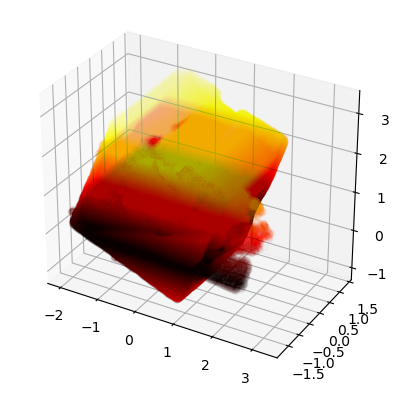

In [4]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', adjustable='box')
plt.show()

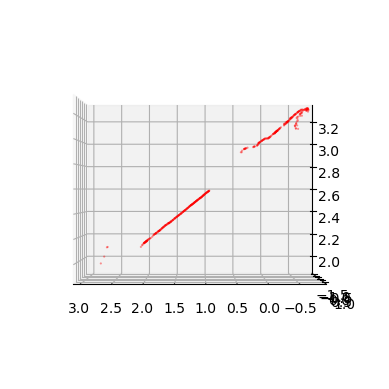

In [4]:
def find_ceiling(col, ssize):
    indices = np.zeros((1, 3))
    end = len(df[col]) // ssize
    ordf = df.sort_values(by=[col])
    for i in reversed(range(end)):
        temp = ordf[i*ssize:(i+1)*ssize]
        idx = temp[['By']].idxmax()
        current = df.iloc[idx].to_numpy()[0].copy()
        if np.max(indices[:,2]) < current[2]:
            indices = np.vstack((indices,current))
    indices = indices[1:,:]
    return indices

ind1 = find_ceiling('#', 250)
ind2 = find_ceiling('Exported', 250)
indices = np.vstack((ind1, ind2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:,0], indices[:,1], indices[:,2], color='r', s=0.3, alpha=0.4)
ax.view_init(elev=0, azim=90)
plt.show()

Equation: 0 = 2.99 + -0.43x + -0.01y - z


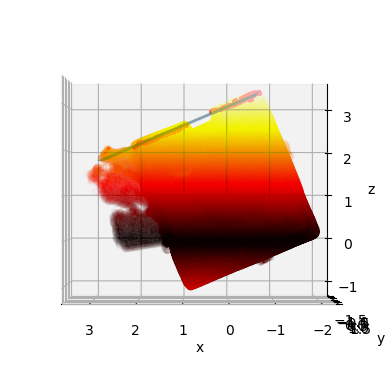

In [5]:
X_train = indices[:, :2]
y_train = indices[:, 2]
X_test = np.random.rand(200).reshape(100,2)*60

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

model = lm.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xrange = indices[:,0]
yrange = indices[:,1]

x = np.linspace(np.min(xrange), np.max(xrange))
y = np.linspace(np.min(yrange), np.max(yrange))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(x, (len(x),1))
ys = np.tile(y, (len(y),1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: 0 = {:.2f} + {:.2f}x + {:.2f}y - z".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', 'box')
ax.view_init(elev=0, azim=90)
plt.show()

In [55]:
def create_rot_mat(coefs):
    norm = -np.array([coefs[0], coefs[1], -1])
    norm = norm / np.linalg.norm(norm)
    basis_x = np.array([1, 0, 0])
    axis = np.cross(norm, basis_x)
    axis = axis / np.linalg.norm(axis)
    angle = -np.arccos(np.dot(norm, basis_x))
    C = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    return np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)

rot_mat = create_rot_mat(coefs)
inv_rot = np.linalg.inv(rot_mat)
mat2d = np.dot(inv_rot, mat.T).T

ceil = mat2d[mat2d[:, 2].argsort()[:80000]][:,:2]

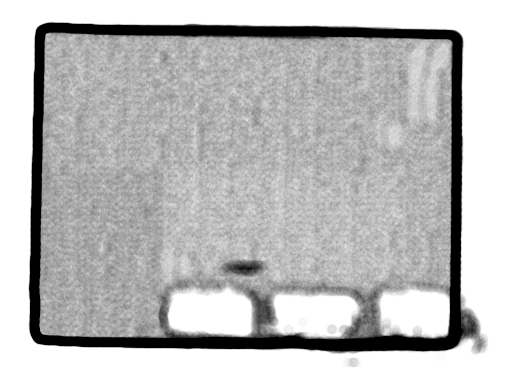

In [56]:
%matplotlib inline

plt.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.01)
plt.axis('off')
plt.savefig('img.png')

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(mat2d[:,0], mat2d[:,1], mat2d[:,2], c=np.abs(mat2d[:,2])/np.max(mat2d), alpha=0.01, cmap='hot')
# # ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='viridis')
# ax.view_init(elev=0, azim=0)
# plt.show

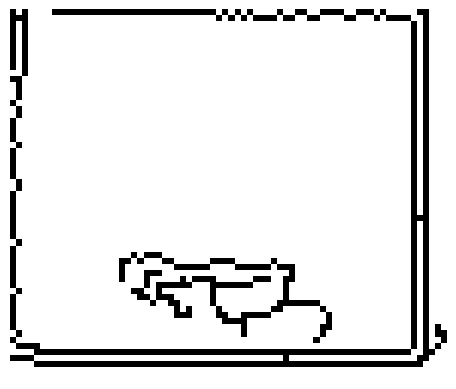

In [31]:
res = 0.05

def point2img(points, res):
    xmin, xmax = np.min(ceil[:, 0]), np.max(ceil[:, 0])
    ymin, ymax = np.min(ceil[:, 1]), np.max(ceil[:, 1])
    shape = (int((xmax - xmin) / res), int((ymax - ymin) / res))
    img  = np.zeros(shape)

    sortx = points[points[:, 0].argsort()]
    sorty = points[points[:, 1].argsort()]

    for i in range(shape[0]):
        for j in range(shape[1]):
            temp = points[np.logical_and(points[:,0]>(xmin + res*i), points[:,0]<(xmin + res*(i+1)))]
            temp = temp[np.logical_and(temp[:,1]>(ymin + res*j), temp[:,1]<(ymin + res*(j+1)))]

            img[i, -j-1] = len(temp)
    return img.T
    
img = point2img(ceil, res)
img = np.ascontiguousarray(255 * img / np.max(img), dtype=np.uint8)
out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
edges = np.uint8((255 - cv2.Canny(out, 50, 150)) // 255)

plt.imshow(edges, cmap='Greys_r')
plt.axis('off')
plt.show()

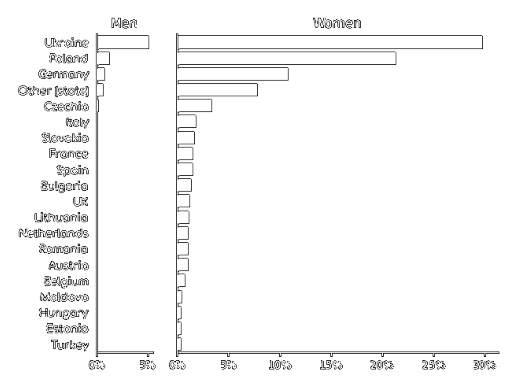

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [103]:
image = cv2.imread('../imengus.github.io/img/fig1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(gray, 50, 150)
# edge = cv2.medianBlur(edges, 3)
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()

edge

In [53]:
def houghlines(out, edges):
    out1 = out.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 10, minLineLength=400, maxLineGap=250)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(out1, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.imshow('out', out1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    # for r_theta in lines:
    #     arr = np.array(r_theta[0], dtype=np.float64)
    #     r, theta = arr

    #     a = np.cos(theta)
    #     b = np.sin(theta)
    
        # x0 = a*r
        # y0 = b*r


        # x1 = int(x0 + 1000*(-b))
        # y1 = int(y0 + 1000*(a))
    
        # x2 = int(x0 - 1000*(-b))
        # y2 = int(y0 - 1000*(a))
        # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # cv2.imwrite('linesDetected.jpg', img)
    # plt.imshow(img, cmap='Greys_r')
    # plt.axis('off')

houghlines(out, edges)

TypeError: 'NoneType' object is not iterable

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread (0x2cfc890).
Cannot move to target thread (0x1ad96a0)

QObject::moveToThread: Current thread (0x1ad96a0) is not the object's thread

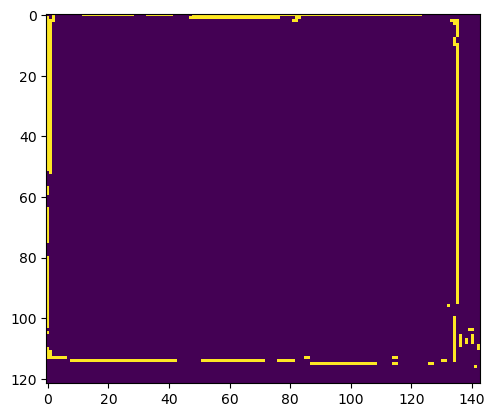

In [138]:
out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# plt.imshow(out)
# plt.show()

# plt.imshow(edges)
# plt.show()

# Median blurring to get rid of the noise; invert image
out2 = 255 - cv2.medianBlur(edges, 3)
out3 = out2.copy()
# Detect and draw lines
lines = cv2.HoughLinesP(out2, 1, np.pi/180, 10, minLineLength=50, maxLineGap=30)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(out3, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv2.imshow('out', out3)
cv2.waitKey(0)
cv2.destroyAllWindows()
# out
# plt.imshow(out2)

In [26]:
edges.shape

(122, 143)

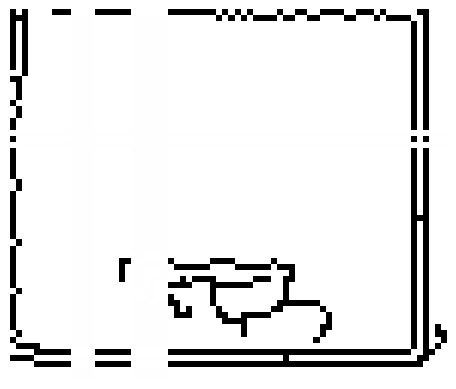

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread

In [35]:
toy = np.zeros((61, 72))

toy[20] = 1
toy[22] = 1

toy[:, 10:14] = 1
toy[:, 20:26] = 1
toy = edges + toy
toy = np.ascontiguousarray(toy, dtype=np.uint8)
# plt.imshow(toy)
toy1 = cv2.cvtColor(toy, cv2.COLOR_GRAY2BGR)
plt.imshow(toy1 * 255)
plt.axis('off')
plt.show()

houghlines(toy1 * 255, toy)
# cv2.imshow('out', toy1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

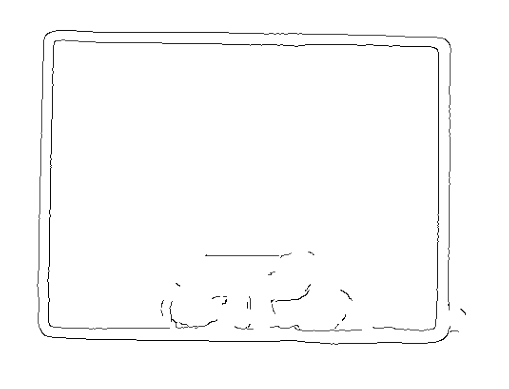

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread (0x2c0b2e0).
Cannot move to target thread (0x1906aa0)

QObject::moveToThread: Current thread (0x1906aa0) is not the object's thread

In [54]:
image = cv2.imread('output.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(gray, 300, 400)
# edge = cv2.medianBlur(edges, 3)
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()
houghlines(image, edge)